In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt;

In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/djbetts/opt/anaconda3/lib/

In [6]:
from src.ItemItemRecommender import ItemItemRecommender
from sklearn.model_selection import train_test_split

In [7]:
from datetime import datetime

In [8]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [9]:
#Current SQL query
"""
SELECT 
geo__country, 
#geo__city,
event_params__video_title,
event_params__videotitle,
event_name,
#COUNT(event_name) AS times_completed,
FROM `jfp-data-warehouse.production_firebase.firebase_event` 
WHERE geo__country in ('Afghanistan',
 'Algeria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Bhutan',
 'Brunei',
 'China',
 'Egypt',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Japan',
 'Jordan',
 'Kazakstan',
 'Kuwait',
 'Kyrgyzstan',
 'Laos',
 'Libya',
 'Malaysia',
 'Maldives',
 'Mali',
 'Mauritania',
 'Mongolia',
 'Morocco',
 'Myanmar',
 'Nepal',
 'Niger',
 'North Korea',
 'Oman',
 'Pakistan',
 'Palestine',
 'Qatar',
 'Russia',
 'Saudia Arabia',
 'Somalia',
 'Sri Lanka',
 'Sudan',
 'Syria',
 'Tajikistan',
 'Thailand',
 'Timor Leste',
 'Tunisia',
 'Turkey',
 'Turkmenistan',
 'UAE',
 'Uzbekistan',
 'Vietnam',
 'Yemen') AND 
event_params__video_title IS NOT NULL AND
event_name IN ('videostarts',  'videoplay',  'a_media_progress10',  'a_media_progress25',  'a_media_progress50',  'a_media_progress75',  'a_media_progress90') AND 
DATE(event_date_partition) 
BETWEEN  "2021-01-01" AND "2021-04-14" 
GROUP BY 
geo__country, 
geo__city,
event_params__videotitle, 
event_params__video_title,
event_name
ORDER BY 
geo__country,
event_params__video_title
#times_completed DESC 
LIMIT 16000
""";

In [119]:
data = pd.read_csv('/Users/djbetts/Desktop/jf_project/data/recommender_base_top_50.csv')


In [120]:
df = data.copy()
#df.drop(['geo__city', 'times_completed'], axis=1, inplace=True)

In [121]:
df.columns

Index(['geo__country', 'event_params__video_title', 'event_params__videotitle',
       'event_name'],
      dtype='object')

In [122]:
def merge_video(df):
    df['video_title'] = df['event_params__videotitle'].fillna(df['event_params__video_title'])
    df.drop(['event_params__videotitle','event_params__video_title'], axis=1, inplace=True)
    return df

In [123]:
def score(event_name):
    d ={
        'videostarts':1,
        'videoplay':1, 
        'a_media_progress10':(1*.1),
        'a_media_progress25':(1*.25),
        'a_media_progress50':(1*.5), 
        'a_media_progress75':(1*.75), 
        'a_media_progress90':(1*.9)
    }
    
    return(d[event_name])

In [124]:
df['video_title'] = df['event_params__videotitle'].fillna(df['event_params__video_title'])

In [125]:
df.drop(['event_params__videotitle','event_params__video_title'], axis=1, inplace=True)

In [126]:
(df.geo__country.value_counts())

India          7243
Egypt          2810
China          2143
Bangladesh     2103
Algeria         621
Afghanistan     390
Bahrain         256
Azerbaijan      233
Bhutan          130
Brunei           71
Name: geo__country, dtype: int64

In [127]:
df.event_name.value_counts()

videoplay             2871
videostarts           2781
a_media_progress10    2408
a_media_progress25    2225
a_media_progress50    2048
a_media_progress75    1891
a_media_progress90    1776
Name: event_name, dtype: int64

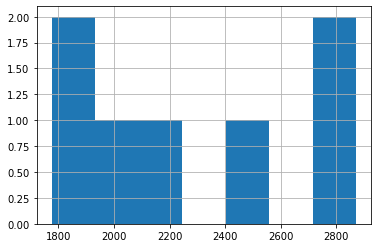

In [128]:
df.event_name.value_counts().hist(bins=7);

In [129]:
df.video_title.value_counts()

Baptism of Jesus by John                                1161
Childhood of Jesus                                      1158
Birth of Jesus                                          1151
JESUS                                                    806
Chosen Witness                                           686
                                                        ... 
使徒行傳                                                       1
JÉSUS                                                      1
Magdalena Explains Jesus&#39; Death and Resurrection       1
圣灵                                                         1
The Wilson Kipsang Story                                   1
Name: video_title, Length: 435, dtype: int64

In [130]:
#df.video_title.hist(bins=435);

# 90% progress through video

In [19]:
#df_90 = df[df['event_name'] == 'a_media_progress90']

In [20]:
#df_90.video_title.unique()

In [21]:
#df_90.geo__country.value_counts()

In [22]:
#country_groupby = df.groupby('geo__country')

In [23]:
#country_groupby['video_title'].unique()

In [24]:
#india = country_groupby.get_group('India')

In [25]:
#falling_plates_india = india[india['video_title'] == '#FallingPlates']

In [26]:
#event_score = falling_plates_india.event_name.value_counts()

In [27]:
#event_score.index

In [28]:
#keys = df.video_title.unique()
#reviews = dict.fromkeys(keys, 0)

In [29]:
#tried to make a function by iterating through a groupby. couldn't figure it out.

# def rating_calculator(group):
#     rating = 0
#     reviews = dict.fromkeys(set(group.video_title), 0)
#     for event_name in group.event_name:
#         if event_name == 'videostarts' or event_name == 'videoplay':
#             reviews[group.video_title] += 1
#         elif event_name == 'a_media_progress10':
#             reviews[group.video_title] += (1 * .1)
#         elif event_name == 'a_media_progress25':
#             reviews[group.video_title] += (1 * .25)
#         elif event_name == 'a_media_progress50':
#             reviews[group.video_title] += (1 * .5)
#         elif event_name == 'a_media_progress75':
#             reviews[group.video_title] += (1 * .75)
#         elif event_name == 'a_media_progress90':
#             reviews[group.video_title] += (1 * .9)
#     print(f'total: {rating}\nnormalized: {rating/len(events)}')
#     return (reviews)
# #     return
# # print(rating)
# # print(rating/len(event_score))

In [30]:
#rating_calculator(event_score)

In [31]:
# #BROKEN
# def review_builder(country_groupby):
#     review_dic = dict.fromkeys(country_groupby.groups.keys(), None)
#     print(review_dic)
#     for country, group in country_groupby:
#         review_dic[country] = rating_calculator(group)
#     return review_dic

# function to return score. not normalized

In [32]:
#view_to_rating('a_media_progress90')

In [33]:
df['score'] = df.event_name.apply(score)

In [34]:
df.drop(['event_name'], axis=1, inplace=True)

<AxesSubplot:>

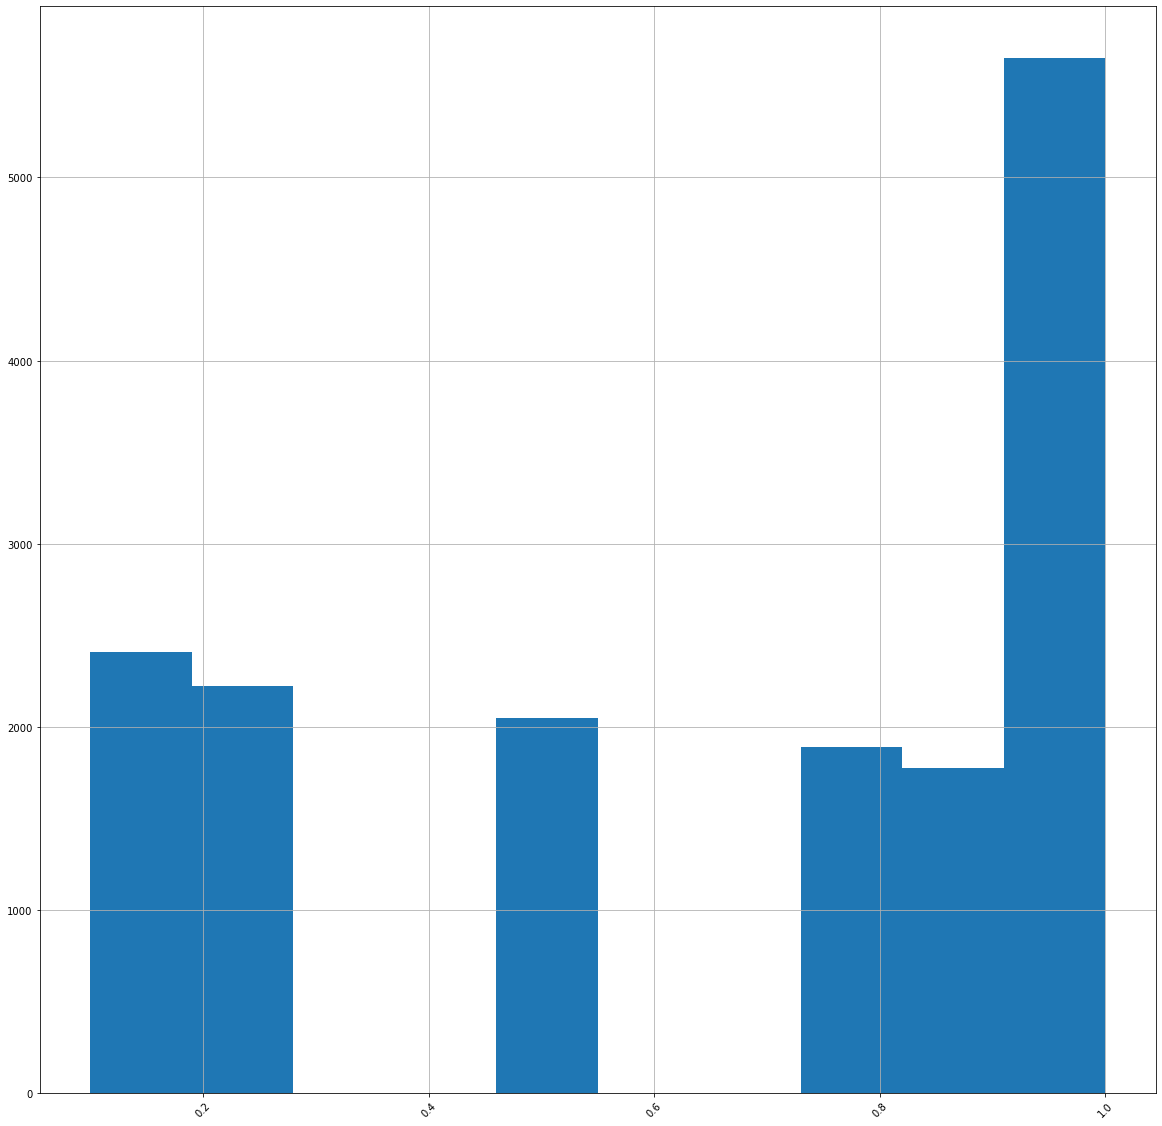

In [35]:
df.score.hist(xrot=45, figsize=(20,20))

In [36]:
groupby = df.groupby(['geo__country','video_title'])

In [37]:
review_scores = groupby.sum()

In [38]:
review_scores.loc[('Bhutan', 'LUMO - John 21:1-25')]

score    2.1
Name: (Bhutan, LUMO - John 21:1-25), dtype: float64

In [39]:
#review_scores.score.plot.bar(figsize=(20,20));

In [40]:
review_scores.loc[('Bhutan','LUMO - John 21:1-25')]

score    2.1
Name: (Bhutan, LUMO - John 21:1-25), dtype: float64

In [41]:
review_scores.unstack()

score                                       \
video_title  #FallingPlates #फालिंगप्लेट्स  #掉落的盘子 1- في العائلة   
geo__country                                                       
Afghanistan            2.00             NaN    NaN           NaN   
Algeria                4.50             NaN    NaN           NaN   
Azerbaijan             4.50             NaN    NaN           NaN   
Bahrain                 NaN             NaN    NaN           NaN   
Bangladesh            11.35             NaN    NaN           NaN   
Bhutan                 2.00             NaN    NaN           NaN   
Brunei                  NaN             NaN    NaN           NaN   
China                  9.00             NaN   13.5           NaN   
Egypt                 15.35             NaN    NaN           2.1   
India                100.15             3.0    NaN           NaN   

                                                                       \
video_title  1. Jesus, Our Loving Pursuer 1.가족 중에 1.우리의 사랑의 추구자이신 예수님   
geo__country                                                            
Afghanistan                           NaN     NaN                 NaN   
Algeria                               NaN     NaN                 NaN   
Azerbaijan                            NaN     NaN                 NaN   
Bahrain                               NaN     NaN                 NaN   
Bangladesh                            4.5     NaN                 NaN   
Bhutan                                NaN     NaN                 NaN   
Brunei                                NaN     NaN                 NaN   
China                                 NaN     NaN                 NaN   
Egypt                                 NaN     NaN                 NaN   
India                                34.5     2.0                 1.0   

                                                          \
video_title  2- عمل يدوي 2. Jesus, Our Gracious Forgiver   
geo__country                                               
Afghanistan          NaN                             NaN   
Algeria              NaN                             NaN   
Azerbaijan           NaN                             NaN   
Bahrain              NaN                             NaN   
Bangladesh           NaN                            3.60   
Bhutan               NaN                             NaN   
Brunei               NaN                             NaN   
China                NaN                             NaN   
Egypt                2.1                            6.65   
India                NaN                           17.10   

                                             ...                            \
video_title  3. Jesus, Our Power for Living  ... 路加福音简介 身份错认于路司得 返回叙利亚的安提阿   
geo__country                                 ...                             
Afghanistan                             NaN  ...    NaN      NaN       NaN   
Algeria                                 NaN  ...    NaN      NaN       NaN   
Azerbaijan                              NaN  ...    NaN      NaN       NaN   
Bahrain                                 NaN  ...    NaN      NaN       NaN   
Bangladesh                              NaN  ...    NaN      NaN       NaN   
Bhutan                                  NaN  ...    NaN      NaN       NaN   
Brunei                                  NaN  ...    NaN      NaN       NaN   
China                                   NaN  ...   6.85      4.5       4.5   
Egypt                                   NaN  ...    NaN      NaN       NaN   
India                                   9.0  ...    NaN      NaN       NaN   

                                                                             
video_title  选出马提亚替代犹大 那些使人犯罪的人有祸了 钉在十字架上的囚犯 雅典的偶像 非斯都咨询亚基帕王 高贵的比里亚人 魔鬼引诱耶稣  
geo__country                                                                 
Afghanistan        NaN         NaN       NaN   NaN       NaN     NaN    NaN  
Algeria            NaN         NaN       NaN   NaN       NaN     NaN    NaN  
A

In [42]:
#review_scores.plot.bar(figsize=(20,20));

In [43]:
review_scores.index

MultiIndex([('Afghanistan',                         '#FallingPlates'),
            ('Afghanistan',                     'Angels at the Tomb'),
            ('Afghanistan',               'Baptism of Jesus by John'),
            ('Afghanistan',                             'Beatitudes'),
            ('Afghanistan',                         'Birth of Jesus'),
            ('Afghanistan',    'Blessed are those Who Hear and Obey'),
            ('Afghanistan',                                'Breathe'),
            ('Afghanistan',                        'Burial of Jesus'),
            ('Afghanistan',                     'Childhood of Jesus'),
            ('Afghanistan',                         'Chosen Witness'),
            ...
            (      'India',                              'Episode 9'),
            (      'India', 'Eutychus Raised From the Dead at Troas'),
            (      'India',        'Explanation of Miraculous Birth'),
            (      'India',                           'Fallin

In [44]:
df_sparce = df.pivot_table(columns='video_title', values='score', index='geo__country', aggfunc='mean', fill_value=0)
movie_list = pd.Series(df_sparce.columns)
users = pd.Series(df_sparce.index)

In [45]:
df_sparce.shape

(10, 435)

In [46]:
number_ratings = (df_sparce.values > 0).sum()
density = number_ratings / (df_sparce.shape[0] * df_sparce.shape[1])
print('The desnsity is: {} '.format(density))

The desnsity is: 0.19057471264367817 


Min number of ratings: 9


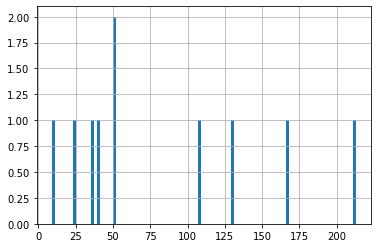

In [47]:
ratings = (df_sparce > 0).sum(axis=1)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

Min number of ratings: 1


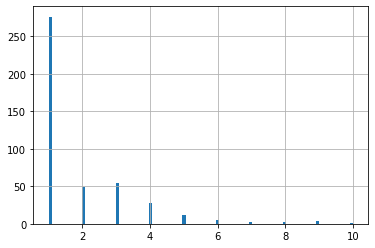

In [48]:
ratings = (df_sparce > 0).sum(axis=0)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))

# utility matric

In [49]:
df_sparce.index

Index(['Afghanistan', 'Algeria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Bhutan', 'Brunei', 'China', 'Egypt', 'India'],
      dtype='object', name='geo__country')

In [50]:
train, test = train_test_split(df_sparce.values, random_state = 100)

In [51]:
ratings_as_mat = csr_matrix(df_sparce.values, (df_sparce.index.shape[0], df_sparce.columns.shape[0]))

In [52]:
print(train.shape)
print(test.shape)
print(df_sparce.shape)

(7, 435)
(3, 435)
(10, 435)


In [53]:
ratings_as_mat.shape

(10, 435)

In [54]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [55]:
users

0    Afghanistan
1        Algeria
2     Azerbaijan
3        Bahrain
4     Bangladesh
5         Bhutan
6         Brunei
7          China
8          Egypt
9          India
Name: geo__country, dtype: object

In [56]:
print(users[3])
rec.pred_one_user(user_id=3)

Bahrain


/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:44: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


array([0.69712845, 0.        , 0.        , 0.64285714, 0.57      ,
       0.        , 0.        , 0.64285714, 0.63180137, 0.        ,
       0.        , 0.        , 0.64285714, 0.64285714, 0.57      ,
       0.63194142, 0.        , 0.        , 0.        , 0.6934121 ,
       0.        , 0.        , 0.        , 0.68330185, 0.63198174,
       0.66435982, 0.        , 0.75023101, 0.67278884, 0.68491811,
       0.68311673, 0.        , 0.68560585, 0.        , 0.68886172,
       0.        , 0.66995805, 0.67373961, 0.69734347, 0.66462635,
       0.68334557, 0.        , 0.64703555, 0.6867959 , 0.6811315 ,
       0.64285714, 0.        , 0.66751123, 0.        , 0.64285714,
       0.        , 0.67809894, 0.69560127, 0.63179959, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.64285714, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.64285714,
       0.        , 0.        , 0.        , 0.66721873, 0.     

# top rated movies

In [57]:
average_rating = df.groupby('video_title').mean()['score']

In [58]:
average_rating.sort_values(ascending=False)

video_title
Day 2: Miraculous Birth      1.00
圣灵                           1.00
Witness to the Son           1.00
The Wilson Kipsang Story     1.00
The Four Principles          1.00
                             ... 
Introduction de Luc          0.57
Faith v. Feeling             0.57
灯的比喻                         0.57
Day 7: Grace on the Cross    0.57
魔鬼引诱耶稣                       0.57
Name: score, Length: 435, dtype: float64

# utility matrix work

In [59]:
index = df.geo__country.unique()

In [60]:
columns = df.video_title.unique()

In [61]:
data = np.zeros((index.shape[0], columns.shape[0]))

In [62]:
reviews = pd.DataFrame(data, index=index, columns=columns)

In [63]:
reviews

,#FallingPlates,Angels at the Tomb,Baptism of Jesus by John,Beatitudes,Birth of Jesus,Blessed are those Who Hear and Obey,Breathe,Burial of Jesus,Childhood of Jesus,Chosen Witness,...,Division in Corinth,Don&#39;t Hold Your Breath,Doubting Thomas,Dying Roads,Eutychus Raised From the Dead at Troas,Falling Away,"Feeding 5,000",Fellowship Of Believers,Festus Consults King Agrippa,Finishing Well
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Azerbaijan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bahrain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bangladesh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bhutan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brunei,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
China,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Egypt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df.head()

,geo__country,video_title,score
0,Afghanistan,#FallingPlates,1.0
1,Afghanistan,#FallingPlates,1.0
2,Afghanistan,Angels at the Tomb,0.1
3,Afghanistan,Angels at the Tomb,0.5
4,Afghanistan,Angels at the Tomb,1.0


# geo__city runthrough

In [10]:
#1. import data
#2. convert to score
#5. drop event_name
#3. merge video titles
#4. remove unlabeled city names
#5. groupby user, item and sum
#6. reset index to create list of reviews

#7. create pivot table to visualize sparse matrix df
#8. create user, movie encoder/id system
#9. encode reviews for scipy.sparse.csr_matrix. index MUST be int not str

#10. test, train, split

In [11]:
#data = pd.read_csv('/Users/djbetts/Desktop/jf_project/data/recommender_top50_geo__city.csv')

In [12]:
data = pd.read_csv('/Users/djbetts/Desktop/jf_project/data/recommender_top50_geo__city_noChina.csv') 

In [13]:
data.columns

Index(['geo__country', 'geo__city', 'event_params__video_title',
       'event_params__videotitle', 'event_name'],
      dtype='object')

In [68]:
df = data.copy()

In [69]:
df = df[df['geo__city'] != '(not set)']

In [70]:
df = merge_video(df)

In [71]:
df['score'] = df['event_name'].apply(score)

In [72]:
df.drop(['event_name'], axis=1, inplace=True)

In [73]:
groupby = df.groupby(['geo__city', 'video_title'])

In [74]:
reviews = groupby.mean()

In [75]:
reviews.reset_index(inplace=True)

In [117]:
reviews

,city_id,movie_id,score
0,1,27,0.642857
1,1,30,0.642857
2,1,41,0.642857
3,1,146,0.642857
4,1,238,0.833333
...,...,...,...
2822,546,148,0.642857
2823,546,157,0.642857
2824,546,196,0.642857
2825,546,202,0.642857


In [76]:
pivot_table = reviews.pivot_table(values='score', index='geo__city', columns='video_title')

In [77]:
cities = pd.Series(pivot_table.index, index=np.arange(1,(len(pivot_table.index)+1)))
#cities['id'] = pd.Series(np.arange(1,(len(cities)+1)))

In [78]:
cities

1      10th of Ramadan City
2       6th of October City
3                  Abu Road
4                     Adoor
5                  Agartala
               ...         
542                   Vyara
543                Warangal
544                  Wardha
545                Yavatmal
546                 Zagazig
Name: geo__city, Length: 546, dtype: object

In [79]:
cities_code = {v: k for k, v in cities.items()}
cities_decode = {v: k for k, v in cities_code.items()}

In [80]:
reviews['city_id'] = reviews.geo__city.replace(to_replace=cities_code)

In [81]:
movies = pd.Series(pivot_table.columns, index=np.arange(1,(len(pivot_table.columns)+1)))

In [82]:
movies

1                    #FallingPlates
2                   #फालिंगप्लेट्स 
3                     1- في العائلة
4      1. Jesus, Our Loving Pursuer
5                           1.가족 중에
                   ...             
272                  النضال والنجاح
273                     سفر الأعمال
274            شفاء من الروح الشرير
275                       طرق الموت
276                       فيلم يسوع
Name: video_title, Length: 276, dtype: object

In [83]:
#movies['id'] = pd.Series(np.arange(1,(len(movies)+1)))

In [84]:
movies_code = {v: k for k, v in movies.items()}
movies_decode = {v: k for k, v in movies_code.items()}

In [85]:
reviews['movie_id'] = reviews.video_title.replace(to_replace=movies_code)

In [86]:
reviews = reviews[['city_id', 'movie_id', 'score']]

In [87]:
reviews

,city_id,movie_id,score
0,1,27,0.642857
1,1,30,0.642857
2,1,41,0.642857
3,1,146,0.642857
4,1,238,0.833333
...,...,...,...
2822,546,148,0.642857
2823,546,157,0.642857
2824,546,196,0.642857
2825,546,202,0.642857


In [88]:
train, test = train_test_split(reviews, random_state = 100)

In [89]:
# Number of users that are in train and not test
len(np.setdiff1d(test.city_id.unique(), train.city_id.unique()))

73

In [90]:
# Number of movies in train and not test
len(np.setdiff1d(test.movie_id.unique(), train.movie_id.unique()))

32

In [91]:
average_rating = reviews.groupby('movie_id').mean()['score']

In [92]:
movies.loc[average_rating.sort_values().index]

movie_id
109                   Faith v. Feeling
275                          طرق الموت
227    StoryClubs: Jesus and Zacchaeus
71           Day 7: Grace on the Cross
69                    Day 5: Zacchaeus
                    ...               
231                Talk with Nicodemus
242                The Four Principles
65           Day 4: Devil Tempts Jesus
176                 LUMO - Luke 1:1-56
258                     Tümlükden Nura
Name: video_title, Length: 276, dtype: object

In [93]:
ratings_as_mat = csr_matrix((train.score, 
        ((train.city_id), (train.movie_id))))

In [94]:
ratings_as_mat.shape

(547, 277)

In [95]:
rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

# Finally testing!

In [97]:
test.groupby('city_id').count().head(20)

,movie_id,score
city_id,,
2,3,3
3,1,1
5,1,1
6,4,4
7,4,4
9,1,1
10,1,1
12,1,1
14,13,13


In [116]:
def test_function(city_id):
    city_name = cities.loc[city_id]
    print(f'City selected: {city_name}')
    
    city_test_df = test[test.city_id == city_id]
    predictions = rec.pred_one_user(user_id=city_id)
    city_test_df['prediction'] = predictions[test[test.city_id == city_id].movie_id.values]
    
    print(city_test_df)
    
    mse = sqrt(mean_squared_error(city_test_df.score, city_test_df.prediction))
    recommend = movies.loc[rec.top_n_recs(user_id=city_id, n=10)]
    
    print(mse)
    print(recommend)

In [98]:
cities.loc[14]

'Alexandria'

In [99]:
city_ten = test[test.city_id == 14]

In [100]:
predictions = rec.pred_one_user(user_id=14)

/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:44: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


In [101]:
city_ten['prediction'] = predictions[test[test.city_id == 14].movie_id.values]
city_ten

/Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,city_id,movie_id,score,prediction
98,14,127,0.587500,0.716321
124,14,217,0.700000,0.693841
117,14,197,0.700000,0.675110
116,14,196,0.642857,0.729992
105,14,157,0.642857,0.679195
110,14,185,0.642857,0.723012
121,14,212,1.000000,0.737688
107,14,173,0.587500,0.000000
115,14,193,0.587500,0.783900
130,14,249,0.587500,0.816016


In [102]:
print(movies.loc[145])
print(movies.loc[251])

Isaiah
The Thief Promised Paradise


In [103]:
city_ten['movie_id_decode'] = city_ten.movie_id.replace(movies_decode)

/Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
city_ten

,city_id,movie_id,score,prediction,movie_id_decode
98,14,127,0.587500,0.716321,Great Commission and Ascension
124,14,217,0.700000,0.693841,Samaritan Woman
117,14,197,0.700000,0.675110,My Last Day
116,14,196,0.642857,0.729992,Miraculous Catch of Fish
105,14,157,0.642857,0.679195,Jesus Proclaims Fulfillment of the Scriptures
110,14,185,0.642857,0.723012,Legion
121,14,212,1.000000,0.737688,Portions
107,14,173,0.587500,0.000000,Jätku Leiba
115,14,193,0.587500,0.783900,Mary Magdalene Freed from Demons
130,14,249,0.587500,0.816016,The Story Short Film


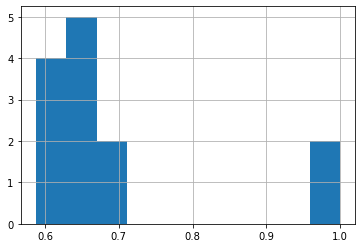

In [105]:
city_ten.score.hist();

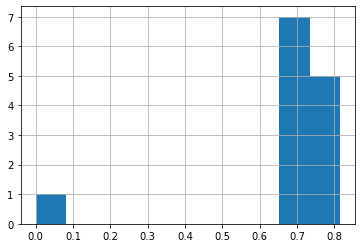

In [106]:
city_ten.prediction.hist();

In [107]:
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(city_ten.score, city_ten.prediction))

0.2313153027487109

In [108]:
#Are these movies already seen?
recommend_10 = movies.loc[rec.top_n_recs(user_id=14, n=10)]

/Users/djbetts/Desktop/jf_project/src/ItemItemRecommender.py:44: RuntimeWarning: invalid value encountered in true_divide
  self.item_sim_mat[item_to_rate, relevant_items].sum()


In [109]:
recommend_10

192                                                Marea
105    Episode 8: I AM the Resurrection and Life - Pa...
227                      StoryClubs: Jesus and Zacchaeus
55                                  Day 1: Cry for Mercy
47                      Confronting Hypocritical Leaders
96          Episode 2: I AM the Bread of Life - Part One
83                            Don&#39;t Hold Your Breath
39                                              Cabernet
118                                             Fracture
126                                                 Good
Name: video_title, dtype: object

In [110]:
cities[14]

'Alexandria'

In [111]:
pivot_table.loc["Alexandria","Marea"]

0.6428571428571429

In [112]:
for movie in recommend_10:
    print(f'{movie}: {pivot_table.loc["Alexandria", movie]}')

Marea: 0.6428571428571429
Episode 8: I AM the Resurrection and Life - Part One: nan
StoryClubs: Jesus and Zacchaeus: nan
Day 1: Cry for Mercy: nan
Confronting Hypocritical Leaders: nan
Episode 2: I AM the Bread of Life - Part One: nan
Don&#39;t Hold Your Breath: nan
Cabernet: nan
Fracture: nan
Good: nan


In [113]:
recommend_10

192                                                Marea
105    Episode 8: I AM the Resurrection and Life - Pa...
227                      StoryClubs: Jesus and Zacchaeus
55                                  Day 1: Cry for Mercy
47                      Confronting Hypocritical Leaders
96          Episode 2: I AM the Bread of Life - Part One
83                            Don&#39;t Hold Your Breath
39                                              Cabernet
118                                             Fracture
126                                                 Good
Name: video_title, dtype: object